In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import time
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###
# Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # For Directml Gpu Configurations
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

# # Font update global for all plots
# plt.rcParams.update({"font.size": 18})

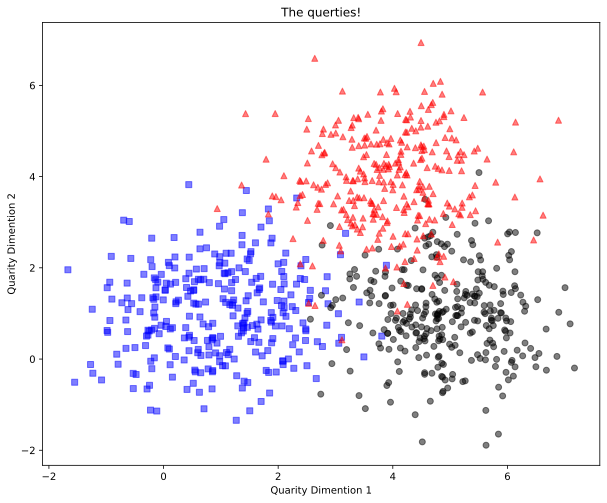

In [12]:
# Create and inspect the data

nPerCluster = 300  ## Change the value to 50 and then 1000 to see the effect on the learning performance
blur = 1

A = [1, 1]
B = [5, 1]
C = [4, 4]

# Generate the data
a = [
    A[0] + np.random.randn(nPerCluster) * blur,
    A[1] + np.random.randn(nPerCluster) * blur,
]
b = [
    B[0] + np.random.randn(nPerCluster) * blur,
    B[1] + np.random.randn(nPerCluster) * blur,
]
c = [
    C[0] + np.random.randn(nPerCluster) * blur,
    C[1] + np.random.randn(nPerCluster) * blur,
]

# True labels
labels_np = np.hstack(
    (np.zeros((nPerCluster)), np.ones((nPerCluster)), 1 + np.ones((nPerCluster)))
)

# Concat into a matrix
data_np = np.hstack((a, b, c)).T

# Convert to pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long()  # note: Long format is for Cross Entropy Loss

# Show the data
fig = plt.figure(figsize=(10, 8))
plt.plot(
    data[np.where(labels.cpu() == 0)[0], 0].cpu(),
    data[np.where(labels.cpu() == 0)[0], 1].cpu(),
    "bs",
    alpha=0.5,
)
plt.plot(
    data[np.where(labels.cpu() == 1)[0], 0].cpu(),
    data[np.where(labels.cpu() == 1)[0], 1].cpu(),
    "ko",
    alpha=0.5,
)
plt.plot(
    data[np.where(labels.cpu() == 2)[0], 0].cpu(),
    data[np.where(labels.cpu() == 2)[0], 1].cpu(),
    "r^",
    alpha=0.5,
)
plt.title("The querties!")
plt.xlabel("Quarity Dimention 1")
plt.ylabel("Quarity Dimention 2")
plt.show()

In [14]:
# Use scikitlearn train_test_split to split the data
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.1
)

# Convert data into pytorch dataset
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

# Finally translate it into dataloader objects
batchsize = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=batchsize,
    shuffle=True,
    drop_last=True,
    generator=torch.Generator(device),
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_dataset.tensors[0].shape[0],
    generator=torch.Generator(device),
)

In [15]:
# how many batches are there?

print(f"There are {len(train_loader)} batches, each with {batchsize} samples.")

There are 25 batches, each with 32 samples.


In [16]:
# Create model function
def createTheQuertyNet(L2_lambda):
    # Class for the QuertyNet
    class QuertyNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Input Layer
            self.input = nn.Linear(2, 8)

            # Hidden Layers
            self.hidden1 = nn.Linear(8, 8)
            self.hidden2 = nn.Linear(8, 8)
            # Output Layer
            self.output = nn.Linear(8, 3)

        # Forwar Pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.hidden1(x))
            x = F.relu(self.hidden2(x))

            return self.output(x)

    # Model Instance
    net = QuertyNet()

    # Loss Function
    lossFun = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=L2_lambda)

    return net, lossFun, optimizer

In [17]:
# test the model with optimizer type as input

# try 'SGD', 'RMSprop', and 'Adam'
optim = createTheQuertyNet(L2_lambda=0.01)[2]
optim

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.01
)

In [18]:
nEpochs = 50


# Function to train the model
def trainTheModel(L2_lambda):
    # Create a new model
    net, lossFun, optimizer = createTheQuertyNet(L2_lambda)

    # Initialize losses
    losses = torch.zeros(nEpochs)
    trainAcc = []
    testAcc = []

    # The Loop
    for epoch in range(nEpochs):

        # Switch to training mode
        net.train()

        # Loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # Forward pass
            yHat = net(X)
            loss = lossFun(yHat, y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss for the batch
            batchLoss.append(loss.item())

            # Comput accuracy
            matches = torch.argmax(yHat, axis=1) == y
            matchesNumeric = matches.float()
            batchAcc.append(100 * (torch.mean(matchesNumeric)).cpu())

            # End of batch loop
        # Average training accuracy across the batches
        trainAcc.append(np.mean(batchAcc))

        # Average losses across batches
        losses[epoch] = np.mean(batchLoss)

        # Test Accuracy
        net.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)
        testAcc.append(
            100 * (torch.mean((torch.argmax(yHat, axis=1) == y).float())).cpu()
        )

    # End of epoch

    # Function Output
    return trainAcc, testAcc, losses, net

In [31]:
# now run through all of them
L2_lambdas = np.linspace(0, .1, 6)
# average performance
trainAccs = np.zeros((nEpochs, len(L2_lambdas)))
testAccs = np.zeros((nEpochs, len(L2_lambdas)))
for i in range(len(L2_lambdas)):
        print(L2_lambdas[i])
        trainAcc, testAcc, losses, net = trainTheModel(L2_lambda=L2_lambdas[i])
        # store the final results
        testAccs[:,i] = testAcc
        trainAccs[:, i] = trainAcc

0.0
0.02
0.04
0.06
0.08
0.1


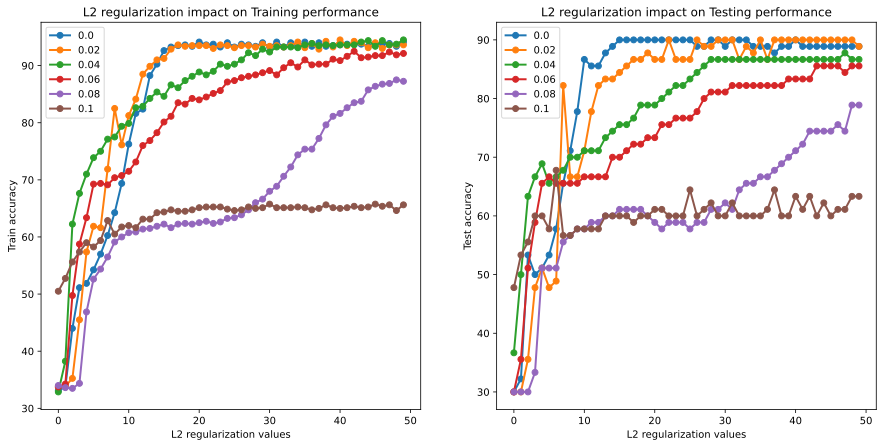

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

ax[0].plot(trainAccs, "o-", linewidth=2)
ax[0].legend(L2_lambdas)
ax[0].set_xlabel("L2 regularization values")
ax[0].set_ylabel("Train accuracy")
ax[0].set_title("L2 regularization impact on Training performance")

ax[1].plot(testAccs, "o-", linewidth=2)
ax[1].legend(L2_lambdas)
ax[1].set_xlabel("L2 regularization values")
ax[1].set_ylabel("Test accuracy")
ax[1].set_title("L2 regularization impact on Testing performance")
plt.show()

In [39]:
# now run through all of them
L2_lambdas = np.linspace(0, 1, 6)
# average performance
trainAccs = np.zeros((nEpochs, len(L2_lambdas)))
testAccs = np.zeros((nEpochs, len(L2_lambdas)))
for i in range(len(L2_lambdas)):
    print(L2_lambdas[i])
    trainAcc, testAcc, losses, net = trainTheModel(L2_lambda=L2_lambdas[i])
    # store the final results
    testAccs[:, i] = testAcc
    trainAccs[:, i] = trainAcc

0.0
0.2
0.4
0.6000000000000001
0.8
1.0


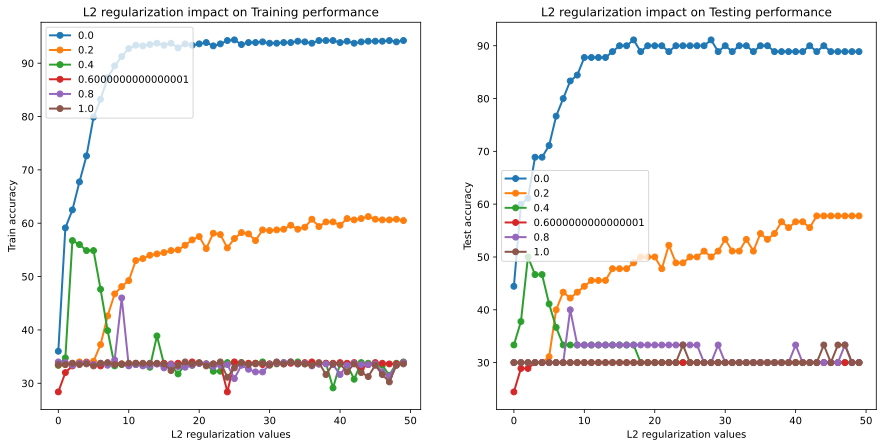

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

ax[0].plot(trainAccs, "o-", linewidth=2)
ax[0].legend(L2_lambdas)
ax[0].set_xlabel("L2 regularization values")
ax[0].set_ylabel("Train accuracy")
ax[0].set_title("L2 regularization impact on Training performance")

ax[1].plot(testAccs, "o-", linewidth=2)
ax[1].legend(L2_lambdas)
ax[1].set_xlabel("L2 regularization values")
ax[1].set_ylabel("Test accuracy")
ax[1].set_title("L2 regularization impact on Testing performance")
plt.show()